# __Seasonality of Netflix Streaming Programmes__

__Dataset__: _https://www.kaggle.com/datasets/risakashiwabara/netfllix-weekly-views-data/data_


## Motivation & Objectives

With a plethora of new programmes coming up almost day across the world, Netflix is one of the foregoing players in Entertainment Streaming Service. Meanwhile other categorical such as marketing and targeting have been well studied for the success of Netflix, this project aims to put a light in different aspect - __explore whether there is a general seasonality in Netflix views across all content.__

## Bottomline Up Front Findings

Despite hints of possible seasonality from a significant 2th lag in both partial autocorrelation (PACF) and autocorrelation (ACF) correlograms and from Exploratory Analysis (EDA), we are not able to contruct a single SARIMA or ARIMAX model to predict the overall seasonality of Netflix programme views.

It is suggested, due to seasonality pattern of the individual categories, an ensemble model is required instead to compute the seasonality of the total views.

## Data Reading

In [2]:
# Load libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
pd.options.display.max_columns = 30

In [3]:
### Load Dataset
df = pd.read_csv('./all-weeks-global.csv',encoding='ISO-8859-1')
df.head()
#print(df.columns)

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,episode_launch_details
0,2024-01-07,Films (English),1,The Equalizer 3,NaN,26800000,1.8167,14800000.0,1,False,NaN
1,2024-01-07,Films (English),2,Rebel Moon ? Part One: A Child of Fire,NaN,25100000,2.2667,11100000.0,3,False,NaN
2,2024-01-07,Films (English),3,Leave the World Behind,NaN,18700000,2.3667,7900000.0,5,False,NaN
3,2024-01-07,Films (English),4,Exodus: Gods and Kings,NaN,18600000,2.5000,7400000.0,1,False,NaN
4,2024-01-07,Films (English),5,Aquaman,NaN,16800000,2.3833,7000000.0,1,False,NaN


In [4]:
### Quick look
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        5280 non-null   object 
 1   category                    5280 non-null   object 
 2   weekly_rank                 5280 non-null   int64  
 3   show_title                  5280 non-null   object 
 4   season_title                2543 non-null   object 
 5   weekly_hours_viewed         5280 non-null   int64  
 6   runtime                     1200 non-null   float64
 7   weekly_views                1200 non-null   float64
 8   cumulative_weeks_in_top_10  5280 non-null   int64  
 9   is_staggered_launch         5280 non-null   bool   
 10  episode_launch_details      46 non-null     object 
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 417.8+ KB


In [5]:
### Some reformating
df["week"] = pd.to_datetime(df["week"],utc = False)
#df.week.unique()

In [6]:
### Check NA 
df.isna().sum()#.any()

week                             0
category                         0
weekly_rank                      0
show_title                       0
season_title                  2737
weekly_hours_viewed              0
runtime                       4080
weekly_views                  4080
cumulative_weeks_in_top_10       0
is_staggered_launch              0
episode_launch_details        5234
dtype: int64

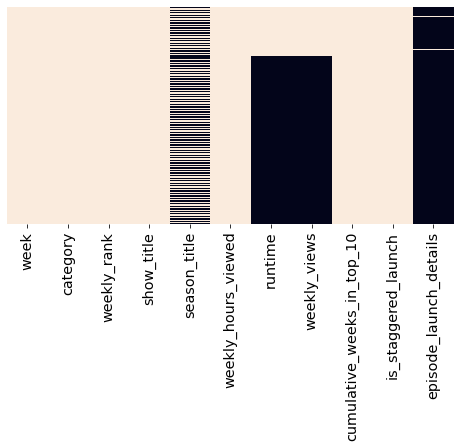

In [7]:
### High level checking NA coverlapping
def plot_na_matrix(df, figsize=(8,4)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_na = df.isna()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_na, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()
    
plot_na_matrix(df)

It is intuitively suggested that **weekly_views** could be the best metric for this analysis. However from the chart above, we can see a significant size of missing data in aforesaid feature. We have to abort it and to use **weekly_hours_viewed** instead as the metric for evalation.

## Exploratory Data Analysis

Text(0.5, 1.0, 'Total Weekly Hours Viewed across Week')

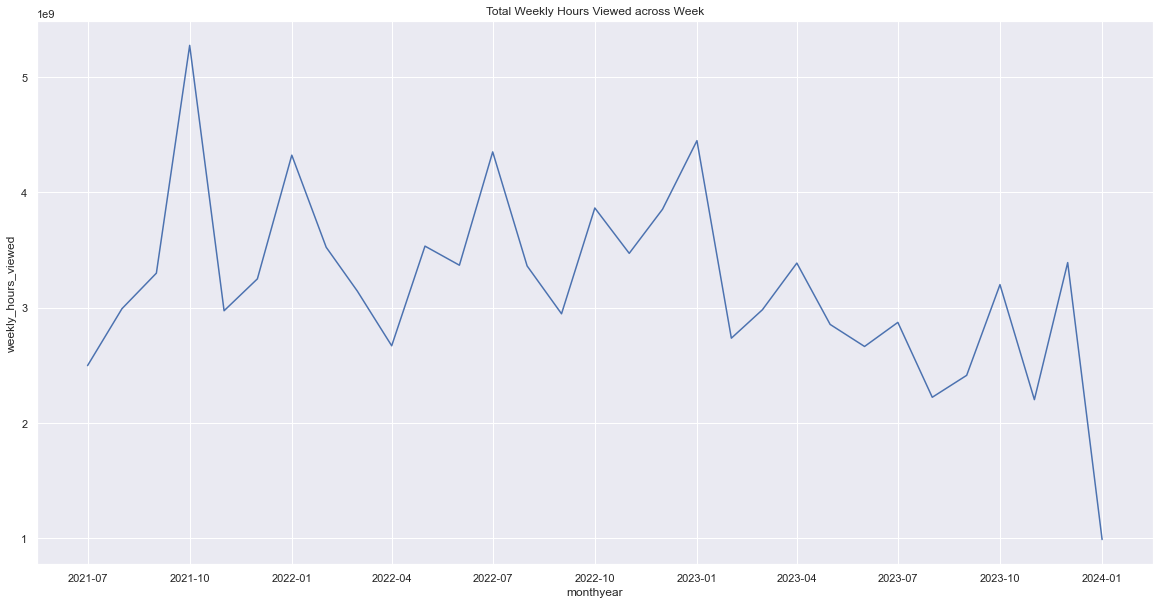

In [8]:
### Quick glimpse on the time-series across week
sns.set_theme(rc={'figure.figsize':(20,10)})

df["monthyear"] = pd.to_datetime(df["week"].to_numpy().astype("datetime64[M]"))
#df["month"] = df["week"].dt.month
#df["month_year"] = df["week"].dt.to_period('M')
summary = df.groupby(by=["monthyear"])["weekly_hours_viewed"].sum()


sns.lineplot(data=summary).set_title("Total Weekly Hours Viewed across Week")


Text(0.5, 1.0, 'Mean Weekly Hours Viewed across Week')

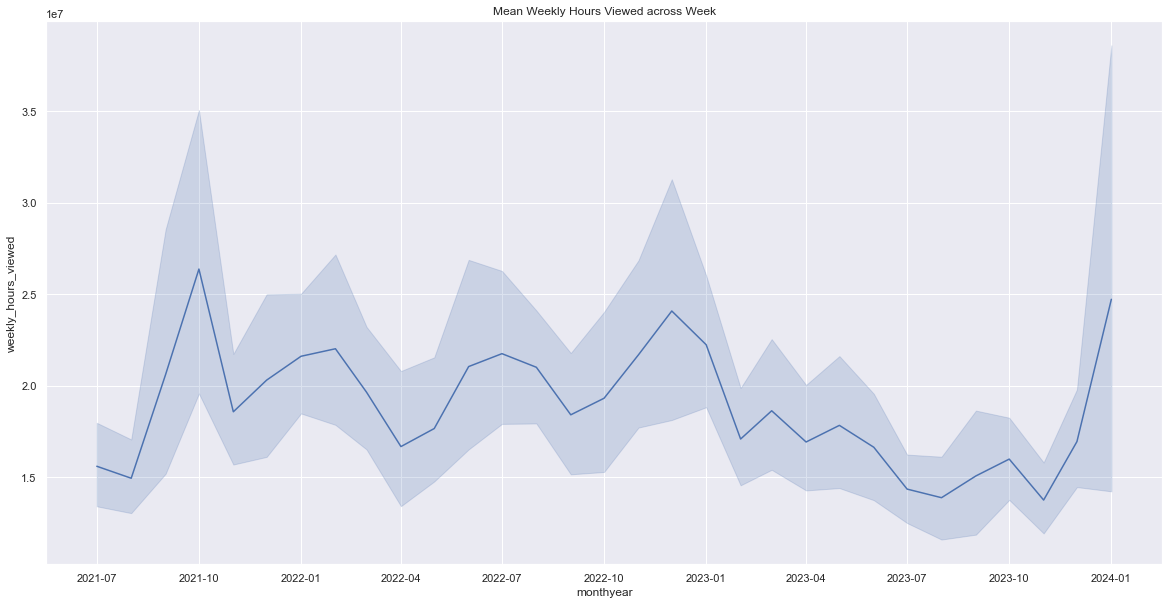

In [9]:
### Quick glimpse on the time-series of mean viewed hour across week
sns.lineplot(data=df, x = "monthyear", y = 'weekly_hours_viewed' ).set_title("Mean Weekly Hours Viewed across Week")

It is observed in general a very subtle seasonality present in views of all Neflix programmes.

From the first time-series, we can very vaguely see a spike of total view hour around every 3 months. 

The seasonlity observation is further supplimented by the second time-series - since 2021, the mean of the viewed hour approaches its yearly peaks usually in between October and the January next year. Potentially, this could be condusive to major holidays (Thanksgiving, Christmas and New Year) happening during the aforementioned period. 

## Seasonality Analysis

In [11]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [12]:
df_total = df.groupby(by=['week'])['weekly_hours_viewed'].sum().reset_index()

In [14]:
def plot_views(df: pd.DataFrame, y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x="week", y=y, labels={"week": "Month"})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text="Weekly Hour Viewed",
                      width=650, title_x=0.5, height=400)

    return fig.show()

plot_views(df_total, "weekly_hours_viewed")

In [15]:
### Boxcox preprocess
# Make the data stationary
df_total["view_Boxcox"], lam = boxcox(df_total["weekly_hours_viewed"])
df_total["view_diff"] = df_total["view_Boxcox"].diff()
df_total.dropna(inplace=True)

# Plot the stationary view data
plot_views(df_total, "view_diff")

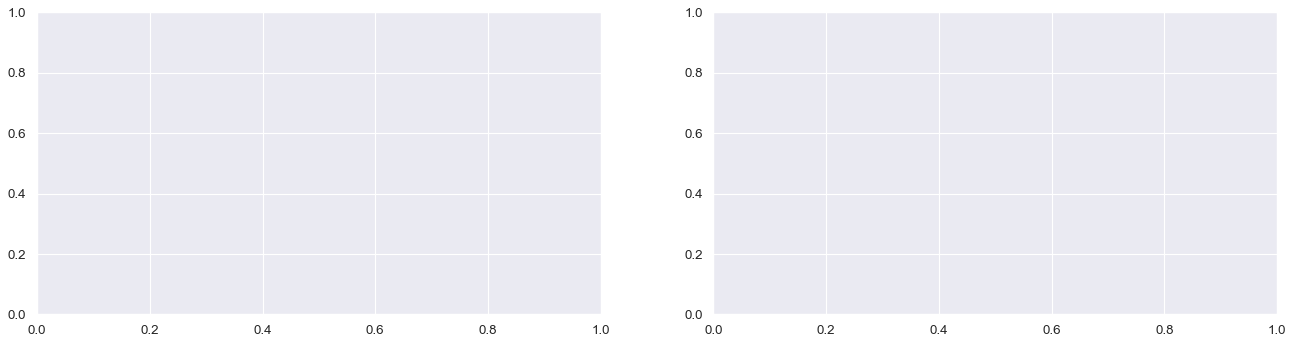

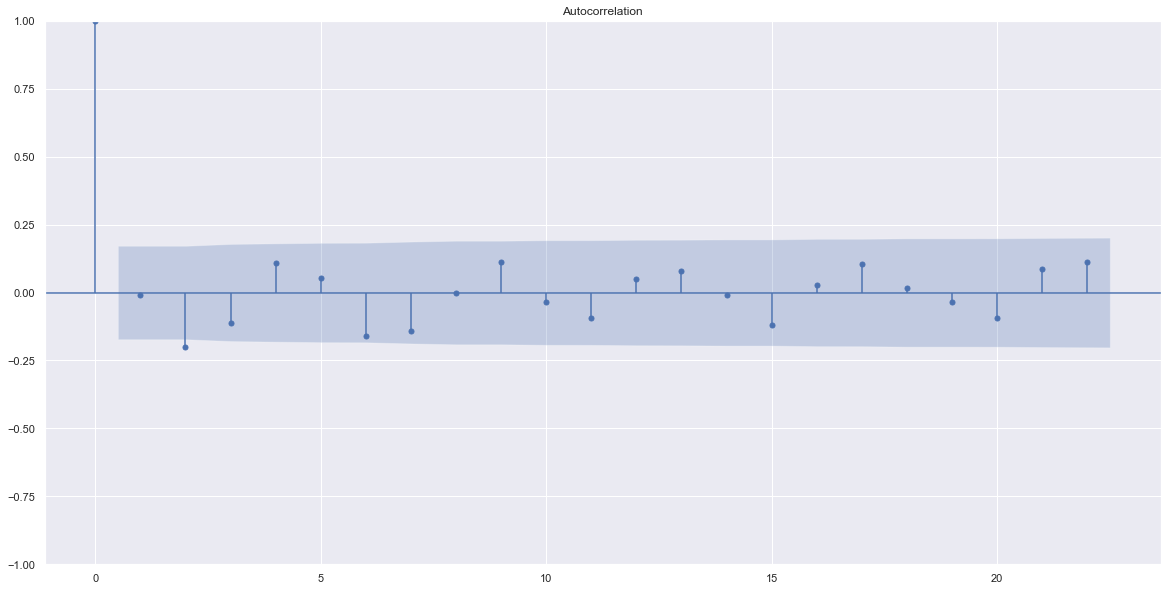

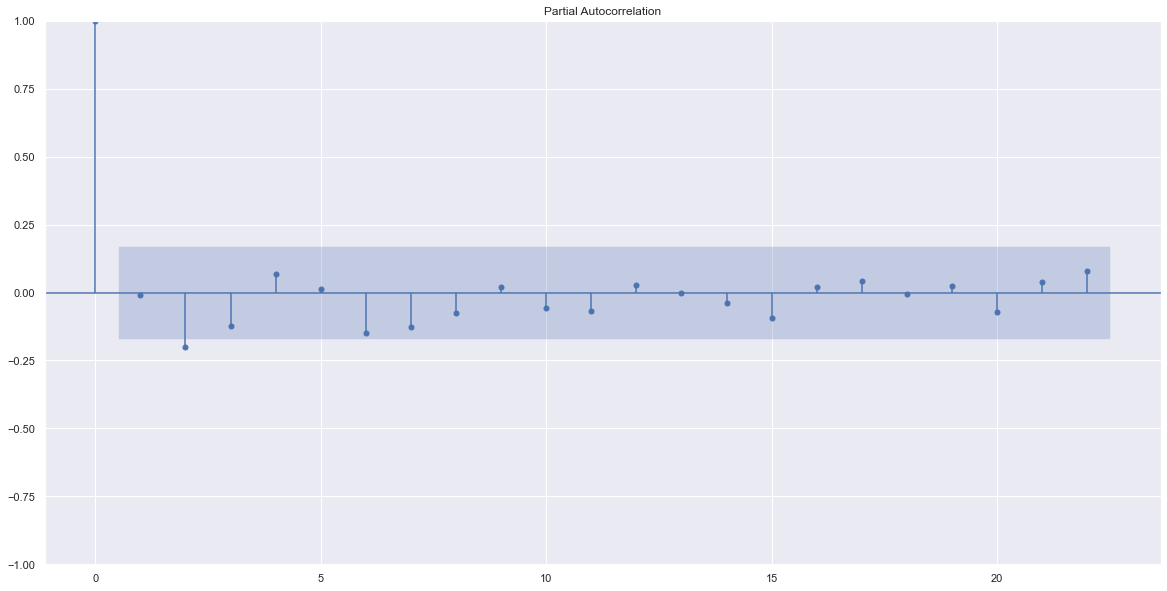

In [16]:
### Modelling
# Plot acf and pacf
fig, axes = plt.subplots(1, 2, figsize=(20, 5), dpi=80)
plot_acf(df_total["view_diff"])
plot_pacf(df_total["view_diff"], method="ywm")
axes[0].tick_params(axis="both", labelsize=12)
axes[1].tick_params(axis="both", labelsize=12)
plt.show()

## Model & Predictions

### SARIMA

In both Partial Autocorrelation (PACF) and Autocorrelation (ACF) correlogram, we could see a subtle signifcant lag in 2nd lag (i.e. p & q parameters). Combining with the 12-month seasonality we found in previous ETA, we are constructing a (2, 1, 2)(1, 1, 1)12 SARIMA model. 

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Shuffle data
#df_total = df_total.sample(frac=1)

# Split train and test
train = df_total.iloc[:-int(len(df_total) * 0.2)]
test = df_total.iloc[-int(len(df_total) * 0.2):]

# Build ARIMA model
model = ARIMA(train["view_Boxcox"], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/suikichan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/suikichan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/suikichan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/suikichan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/suikichan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [18]:
def plot_forecasts(forecasts, title: str) -> None:
    """Function to plot the forecasts."""
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train["week"], y=train["weekly_hours_viewed"], name='Train'))
    fig.add_trace(go.Scatter(x=test["week"], y=test["weekly_hours_viewed"], name='Test'))
    fig.add_trace(go.Scatter(x=test["week"], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=1200, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title="weekly_hours_viewed")

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'SARIMA')



Oops. :(. This does not look good.

### ARIMAX

As a second attempt, here we are constructing a harmonised auto-ARIMA with Fourier as exogenous features, i.e. a ARIMAX.

In [24]:
import pmdarima as pm

In [31]:
# Get fourier features
df_total['month_num'] = df_total['week'].dt.month
for order in range(1, 10):
    df_total[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * df_total['month_num'] / 12)
    df_total[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * df_total['month_num'] / 12)

# name of fourier features
fourier_features = [i for i in list(df_total) if i.startswith('fourier')]

# Split train and test
train = df_total.iloc[:-int(len(df_total) * 0.2)]
test = df_total.iloc[-int(len(df_total) * 0.2):]

# Build auto-ARIMA model with fourier features
model = pm.auto_arima(train["view_Boxcox"],
                      X=train[fourier_features],
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      max_order=None,
                      information_criterion='aicc',
                      error_action="ignore")

# Get the forecasts and apply inverse box-cox transform
boxcox_forecasts = model.predict(n_periods=len(test), X=test[fourier_features])
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/suikichan/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [32]:
# Plot the forecasts
plot_forecasts(forecasts, 'ARIMAX')

This looks even worse.

## Conclusion and Further Discussions

Although we are not able to contruct a promising model from SARIMA & ARIMAX to predict __total__ view data seasonality of Netflix programmes, the PACF, ACF and EDA could confirm the presence of possible seasonality contributing.

It is therefore suggested that the views of Netflix is more complex and cannot be solely modelled by SARIMA & ARIMAX. 

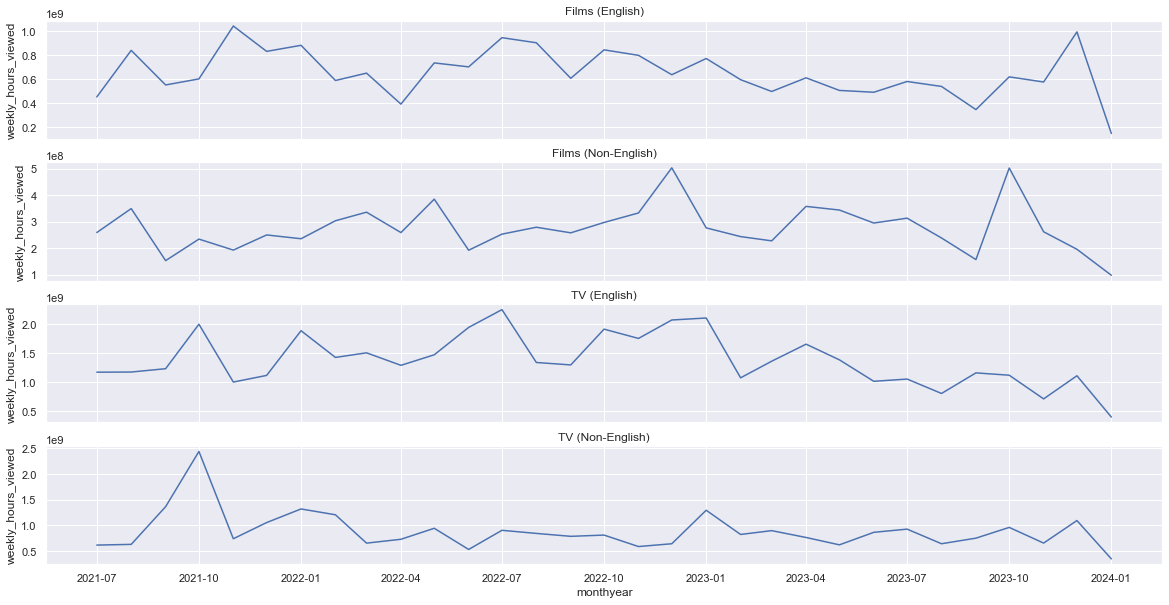

In [10]:
### Time-series of different categories
fig, axes = plt.subplots(4,1, figsize=(20, 10), sharex=True)
for n in range(len(df.category.unique())):
    cat = df.category.unique()[n]
    df_part = df[df["category"] == cat]
    sns.lineplot(ax=axes[n], data=df_part, x = "monthyear", y = 'weekly_hours_viewed', estimator="sum", ci=None)
    axes[n].set_title(f"{cat}")

One follow-up finding is the pattern of different categories of Netflix programmes, shown above, have fairly different seasonality patterns. 

For instances, zooming into major contributors, the _"Films (English)"_ category manifests a peak pattern in rounghly every three months interval, whereas the _"TV (Englsih)"_ shows a pattern appeared more "random".

These could ensemble a more complicated, if not irregular, seasonality pattern that one single SARIMAX/ ARIMAX could not be able to capture. There could also be sub-graph or biases from other factors/features, such as genres, that could help construct a more reliable ensemble seasonality of Netflix views.